<a href="https://colab.research.google.com/github/danilsab24/Project-CV/blob/main/ASL_hand_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import of Librerie

In [1]:
import zipfile
import os

from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import ToPILImage

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [3]:
# Define the path to your zip file
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/copia_dataset.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [ ]:
# Percorso della cartella di train
train_dir = "/content/sample_data/copia_dataset"

# Controlla quante cartelle ci sono e per ogni cartella il numero di immagini presenti
def count_images_in_folders(directory):
    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    folder_image_counts = {}

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        folder_image_counts[folder] = len(images)

    return folder_image_counts

# Esegui la funzione e stampa i risultati
folder_image_counts = count_images_in_folders(train_dir)

print(f"Numero totale di cartelle: {len(folder_image_counts)}\n")
for folder, count in folder_image_counts.items():
    print(f"Cartella '{folder}' contiene {count} immagini.")


Numero totale di cartelle: 4

Cartella 'asl_alphabet_test' contiene 0 immagini.
Cartella 'asl_alphabet_train' contiene 0 immagini.
Cartella 'output' contiene 0 immagini.
Cartella 'asl_alphabet_validation' contiene 0 immagini.


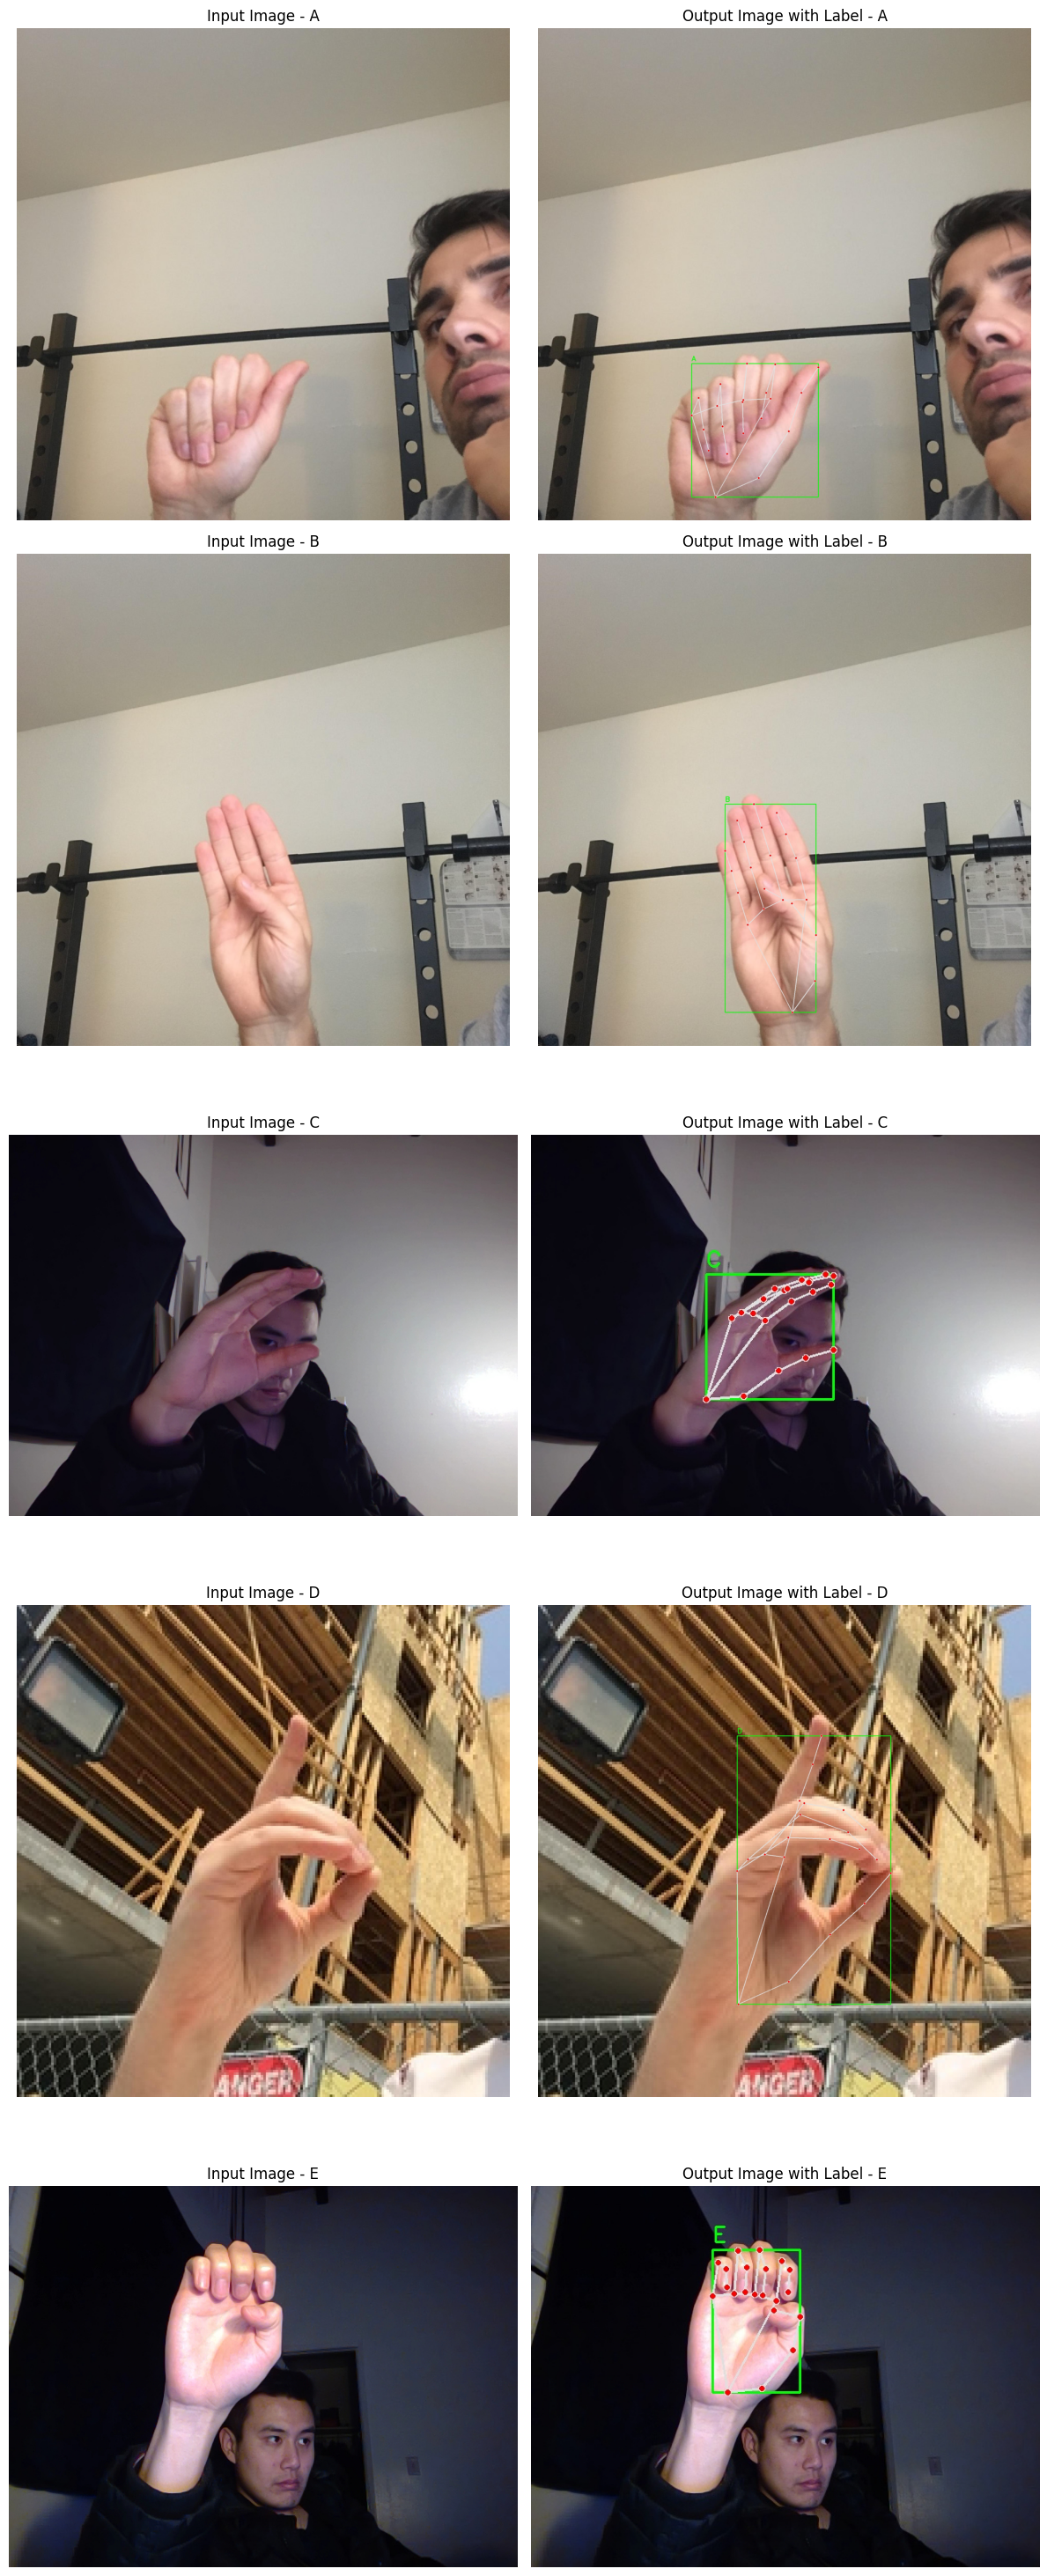

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def plot_images_from_multiple_labels(input_dir, output_dir, labels, images_per_label=1):
    fig, axes = plt.subplots(images_per_label * len(labels), 2, figsize=(12, 6*images_per_label*len(labels)))

    count = 0
    for label in labels:
        input_path = os.path.join(input_dir, label)
        output_path = os.path.join(output_dir, f"{label}_label")

        input_images = sorted(os.listdir(input_path))[:images_per_label]

        for input_image in input_images:
            input_image_path = os.path.join(input_path, input_image)
            output_image_name = input_image.split('.')[0] + '_label.' + input_image.split('.')[1]  # assuming the images have extensions like .jpg or .png
            output_image_path = os.path.join(output_path, output_image_name)

            if not os.path.exists(output_image_path):
                print(f"Warning: Corresponding output image not found for {input_image_path}")
                continue

            input_img = Image.open(input_image_path)
            output_img = Image.open(output_image_path)

            axes[count, 0].imshow(input_img)
            axes[count, 0].set_title(f'Input Image - {label}')
            axes[count, 0].axis('off')

            axes[count, 1].imshow(output_img)
            axes[count, 1].set_title(f'Output Image with Label - {label}')
            axes[count, 1].axis('off')

            count += 1

    plt.tight_layout()
    plt.show()

# Directory paths
base_dir = '/content/sample_data/copia_dataset'
input_dir = os.path.join(base_dir, 'asl_alphabet_train')
output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_train')

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E']  # Change these to the labels you want to plot

# Plot images from multiple labels
plot_images_from_multiple_labels(input_dir, output_dir, labels, images_per_label=1)


In [ ]:
import shutil
from pathlib import Path

# Percorso della directory da svuotare
directory_to_clear = Path('/content/sample_data/copia_dataset')

# Funzione per eliminare tutto il contenuto della directory
def clear_directory(directory_path):
    if directory_path.exists() and directory_path.is_dir():
        shutil.rmtree(directory_path)
        print(f"Tutto il contenuto di {directory_path} è stato eliminato.")
        # Ricrea la directory dopo averla eliminata
        directory_path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"La directory {directory_path} non esiste o non è una directory valida.")

# Esegui la funzione per svuotare la directory
#clear_directory(directory_to_clear)


Tutto il contenuto di /content/sample_data/copia_dataset è stato eliminato.


In [ ]:
def check_image_dimensions(directory):
    dimensions = None
    all_same = True

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg')):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    current_dimensions = img.size

                    if dimensions is None:
                        dimensions = current_dimensions
                    elif current_dimensions != dimensions:
                        print(f"Dimension mismatch found in file: {image_path} (Dimensions: {current_dimensions})")
                        all_same = False

    if all_same:
        print("All images have the same dimensions:", dimensions)
    else:
        print("Not all images have the same dimensions.")

# Path to the directory containing the images
directory_path = "/content/sample_data/copia_dataset"

# Check if all images have the same dimensions
check_image_dimensions(directory_path)

# Code for trainloader validation loader e trainloader



In [ ]:
class ASLAlphabetDataset(Dataset):
    def __init__(self, input_dir, output_dir, labels, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.labels = labels
        self.transform = transform
        self.image_pairs = self._create_image_pairs()

    def _create_image_pairs(self):
        image_pairs = []
        for label in self.labels:
            input_path = os.path.join(self.input_dir, label)
            output_path = os.path.join(self.output_dir, f"{label}_label")

            input_images = sorted(os.listdir(input_path))

            for input_image in input_images:
                input_image_path = os.path.join(input_path, input_image)
                output_image_name = input_image.rsplit('.', 1)[0] + '_label.' + input_image.rsplit('.', 1)[1]
                output_image_path = os.path.join(output_path, output_image_name)

                if os.path.exists(output_image_path):
                    image_pairs.append((input_image_path, label))  # Store the label instead of the output image path
                else:
                    print(f"Warning: Corresponding output image not found for {input_image_path}")

        return image_pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_image_path, label = self.image_pairs[idx]
        input_image = Image.open(input_image_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)

        label_index = self.labels.index(label)  # Convert label to index

        return input_image, label_index

# Directory paths
base_dir = '/content/sample_data/copia_dataset'
train_input_dir = os.path.join(base_dir, 'asl_alphabet_train')
validation_input_dir = os.path.join(base_dir, 'asl_alphabet_validation')
test_input_dir = os.path.join(base_dir, 'asl_alphabet_test')

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'del', 'nothing', 'space']

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = ASLAlphabetDataset(train_input_dir, train_output_dir, labels, transform=transform)
validation_dataset = ASLAlphabetDataset(validation_input_dir, validation_output_dir, labels, transform=transform)
test_dataset = ASLAlphabetDataset(test_input_dir, test_output_dir, labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example of iterating through the data loader
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break

Output streaming troncato alle ultime 5000 righe.


IndexError: index 3 is out of bounds for axis 1 with size 3

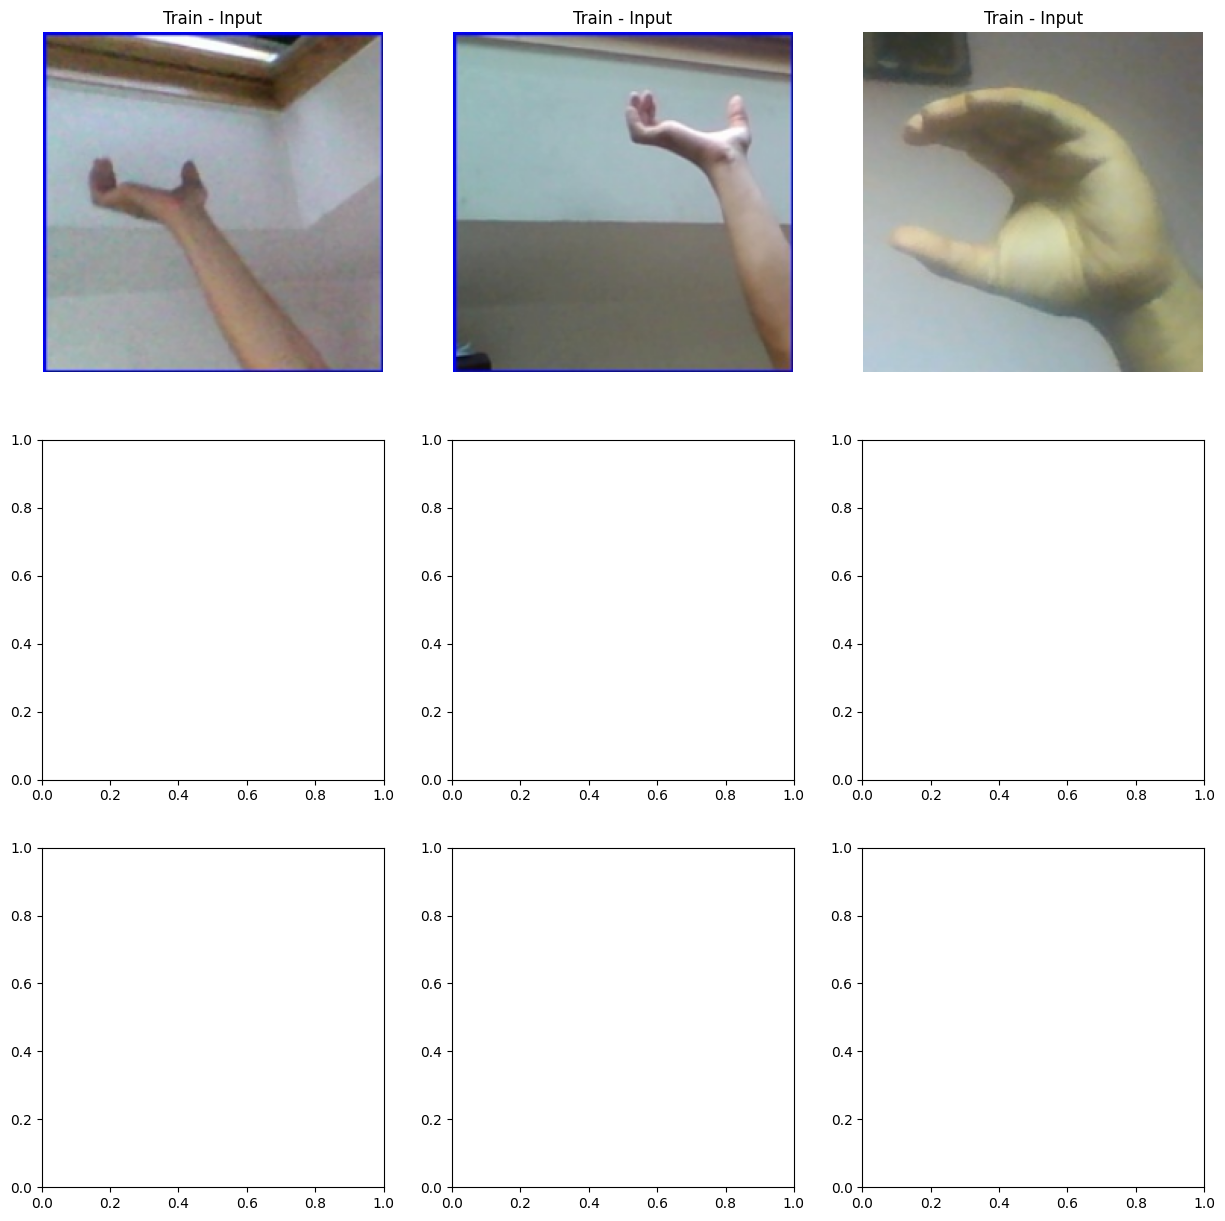

In [38]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ASLAlphabetDataset(Dataset):
    def __init__(self, input_dir, output_dir, labels, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.labels = labels
        self.transform = transform
        self.image_pairs = self._create_image_pairs()

    def _create_image_pairs(self):
        image_pairs = []
        for label in self.labels:
            input_path = os.path.join(self.input_dir, label)
            output_path = os.path.join(self.output_dir, f"{label}_label")

            input_images = sorted(os.listdir(input_path))

            for input_image in input_images:
                input_image_path = os.path.join(input_path, input_image)
                output_image_name = input_image.rsplit('.', 1)[0] + '_label.' + input_image.rsplit('.', 1)[1]
                output_image_path = os.path.join(output_path, output_image_name)

                if os.path.exists(output_image_path):
                    image_pairs.append((input_image_path, output_image_path, label))  # Store the label along with paths
                else:
                    print(f"Warning: Corresponding output image not found for {input_image_path}")

        return image_pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_image_path, output_image_path, label = self.image_pairs[idx]
        input_image = Image.open(input_image_path).convert("RGB")
        output_image = Image.open(output_image_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        label_index = self.labels.index(label)  # Convert label to index

        return input_image, output_image, label_index

# Directory paths
base_dir = '/content/sample_data/copia_dataset'
train_input_dir = os.path.join(base_dir, 'asl_alphabet_train')
validation_input_dir = os.path.join(base_dir, 'asl_alphabet_validation')
test_input_dir = os.path.join(base_dir, 'asl_alphabet_test')

# Output directories
train_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_train')
validation_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_validation')
test_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_test')

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'del', 'nothing', 'space']

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = ASLAlphabetDataset(train_input_dir, train_output_dir, labels, transform=transform)
validation_dataset = ASLAlphabetDataset(validation_input_dir, validation_output_dir, labels, transform=transform)
test_dataset = ASLAlphabetDataset(test_input_dir, test_output_dir, labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to display images
def imshow(image, ax, title):
    image = image.permute(1, 2, 0)  # Change to HWC
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
    image = torch.clamp(image, 0, 1)  # Clamp values to be between 0 and 1
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

# Plotting images from train, validation, and test datasets
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (loader, dataset_type) in enumerate(zip([train_loader, validation_loader, test_loader], ['Train', 'Validation', 'Test'])):
    inputs, outputs, labels = next(iter(loader))
    for j in range(3):
        ax = axes[i, j]
        imshow(inputs[j], ax, title=f'{dataset_type} - Input')
        ax = axes[i, j+1]
        imshow(outputs[j], ax, title=f'{dataset_type} - Expected Output')

plt.tight_layout()
plt.show()


In [18]:
def find_unmatched_images(input_dir, output_dir, labels):
    unmatched_count = 0
    unmatched_images = []

    for label in labels:
        input_path = os.path.join(input_dir, label)
        output_path = os.path.join(output_dir, f"{label}_label")

        input_images = sorted(os.listdir(input_path))

        for input_image in input_images:
            input_image_path = os.path.join(input_path, input_image)
            output_image_name = input_image.rsplit('.', 1)[0] + '_label.' + input_image.rsplit('.', 1)[1]
            output_image_path = os.path.join(output_path, output_image_name)

            if not os.path.exists(output_image_path):
                unmatched_count += 1
                unmatched_images.append(input_image_path)

    return unmatched_count, unmatched_images

# Directory paths
base_dir = '/content/sample_data/copia_dataset'
train_input_dir = os.path.join(base_dir, 'asl_alphabet_train')
validation_input_dir = os.path.join(base_dir, 'asl_alphabet_validation')
test_input_dir = os.path.join(base_dir, 'asl_alphabet_test')

train_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_train')
validation_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_validation')
test_output_dir = os.path.join(base_dir, 'output', 'asl_alphabet_test')

# Labels to consider
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'del', 'nothing', 'space']

# Find unmatched images in train, validation and test sets
train_unmatched_count, train_unmatched_images = find_unmatched_images(train_input_dir, train_output_dir, labels)
validation_unmatched_count, validation_unmatched_images = find_unmatched_images(validation_input_dir, validation_output_dir, labels)
test_unmatched_count, test_unmatched_images = find_unmatched_images(test_input_dir, test_output_dir, labels)

total_unmatched_count = train_unmatched_count + validation_unmatched_count + test_unmatched_count

print(f"Total unmatched images: {total_unmatched_count}")
print(f"Train unmatched images: {train_unmatched_count}")
print(f"Validation unmatched images: {validation_unmatched_count}")
print(f"Test unmatched images: {test_unmatched_count}")


Total unmatched images: 11147
Train unmatched images: 7415
Validation unmatched images: 1752
Test unmatched images: 1980


# CNN

In [19]:
class HandGestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandGestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
num_classes = 29
model = HandGestureCNN(num_classes=num_classes)

In [21]:
# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

HandGestureCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=29, bias=True)
)

# Train

In [22]:
import copy
import torch
from tqdm import tqdm

# Liste per tracciare le metriche
train_losses = []
val_losses = []
val_accuracies = []

# Definizione del loop di addestramento e validazione
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Ogni epoca ha una fase di addestramento e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Impostare il modello in modalità training
                dataloader = train_loader
            else:
                model.eval()  # Impostare il modello in modalità evaluation
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterare sui dati con tqdm per visualizzare la barra di progresso
            for inputs, labels in tqdm(dataloader, desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Resettare i gradienti dell'ottimizzatore
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Controllo delle dimensioni
                    if outputs.size(0) != labels.size(0):
                        raise ValueError(f'Dimensioni batch mismatch: outputs {outputs.size(0)}, labels {labels.size(0)}')

                    loss = criterion(outputs, labels)

                    # Backward + ottimizzazione solo nella fase di addestramento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Salvare le metriche
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Copiare il modello se ha migliorato la accuratezza su validation
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # Caricare i pesi migliori del modello
    model.load_state_dict(best_model_wts)
    return model

# Esegui l'addestramento del modello
model = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=15)

# Percorso di salvataggio
save_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'

# Salvare il modello e le metriche
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}, save_path)

print(f"Modello e metriche salvate con successo in {save_path}.")

Epoch 0/14
----------


train Loss: 0.8985 Acc: 0.7252


val Loss: 0.1958 Acc: 0.9452
Epoch 1/14
----------


train Loss: 0.2546 Acc: 0.9205


val Loss: 0.1195 Acc: 0.9701
Epoch 2/14
----------


train Loss: 0.1568 Acc: 0.9526


val Loss: 0.0871 Acc: 0.9788
Epoch 3/14
----------


train Loss: 0.1182 Acc: 0.9643


val Loss: 0.0827 Acc: 0.9823
Epoch 4/14
----------


train Loss: 0.0977 Acc: 0.9711


val Loss: 0.0986 Acc: 0.9801
Epoch 5/14
----------


train Loss: 0.0850 Acc: 0.9763


val Loss: 0.0860 Acc: 0.9826
Epoch 6/14
----------


train Loss: 0.0753 Acc: 0.9779


val Loss: 0.0955 Acc: 0.9831
Epoch 7/14
----------


train Loss: 0.0734 Acc: 0.9802


val Loss: 0.1091 Acc: 0.9806
Epoch 8/14
----------


train Loss: 0.0671 Acc: 0.9816


val Loss: 0.0921 Acc: 0.9845
Epoch 9/14
----------


train Loss: 0.0651 Acc: 0.9831


val Loss: 0.0957 Acc: 0.9862
Epoch 10/14
----------


train Loss: 0.0612 Acc: 0.9840


val Loss: 0.1339 Acc: 0.9831
Epoch 11/14
----------


train Loss: 0.0608 Acc: 0.9847


val Loss: 0.1165 Acc: 0.9843
Epoch 12/14
----------


train Loss: 0.0590 Acc: 0.9854


val Loss: 0.1336 Acc: 0.9826
Epoch 13/14
----------


train Loss: 0.0605 Acc: 0.9863


val Loss: 0.1028 Acc: 0.9859
Epoch 14/14
----------


train Loss: 0.0585 Acc: 0.9862


val Loss: 0.1361 Acc: 0.9861
Best val Acc: 0.9862
Modello e metriche salvate con successo in /content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth.


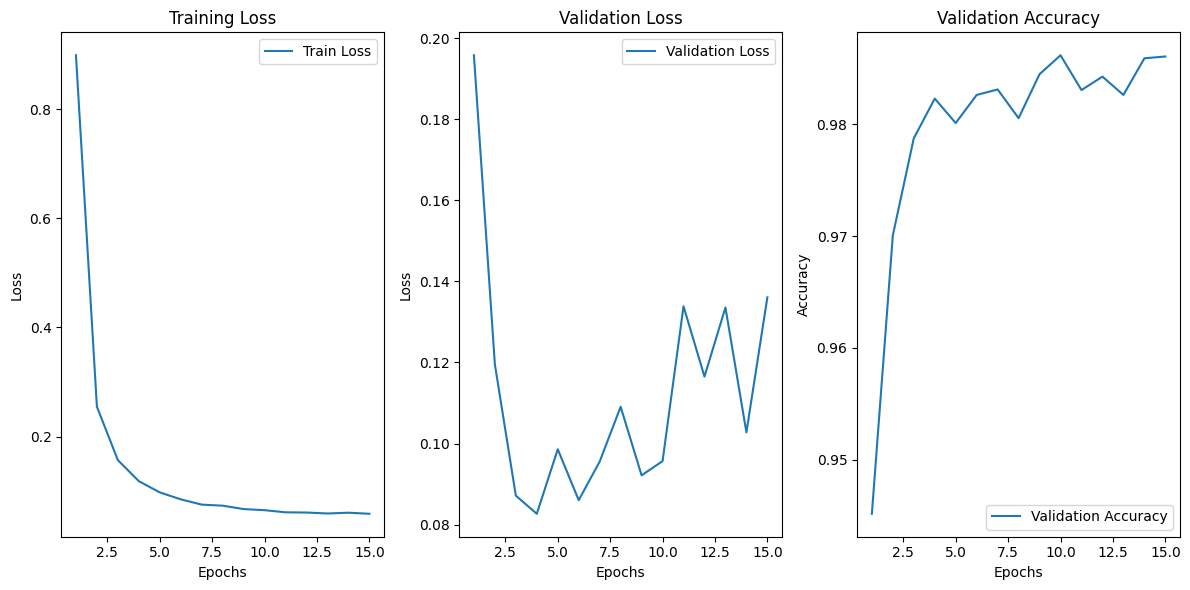

In [23]:
# Percorso del file salvato
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'

# Caricamento del file
checkpoint = torch.load(file_path)

# Recupero delle metriche
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

# Conversione dei tensori in numpy arrays se necessario
if isinstance(val_accuracies[0], torch.Tensor):
    val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plot delle metriche
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot del training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot del validation loss
plt.subplot(1, 3, 2)
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plot della validation accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Test of CNN

Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F1 Score: 0.9991
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       767
           B       1.00      1.00      1.00       759
           C       1.00      1.00      1.00       735
           D       1.00      1.00      1.00       684
           E       1.00      1.00      1.00       700
           F       1.00      1.00      1.00       727
           G       1.00      1.00      1.00       708
           H       1.00      1.00      1.00       714
           I       1.00      1.00      1.00       719
           J       1.00      1.00      1.00       676
           K       1.00      1.00      1.00       713
           L       1.00      1.00      1.00       718
           M       1.00      1.00      1.00       714
           N       1.00      1.00      1.00       718
           O       1.00      1.00      1.00       735
           P       1.00      1.00      1.00  

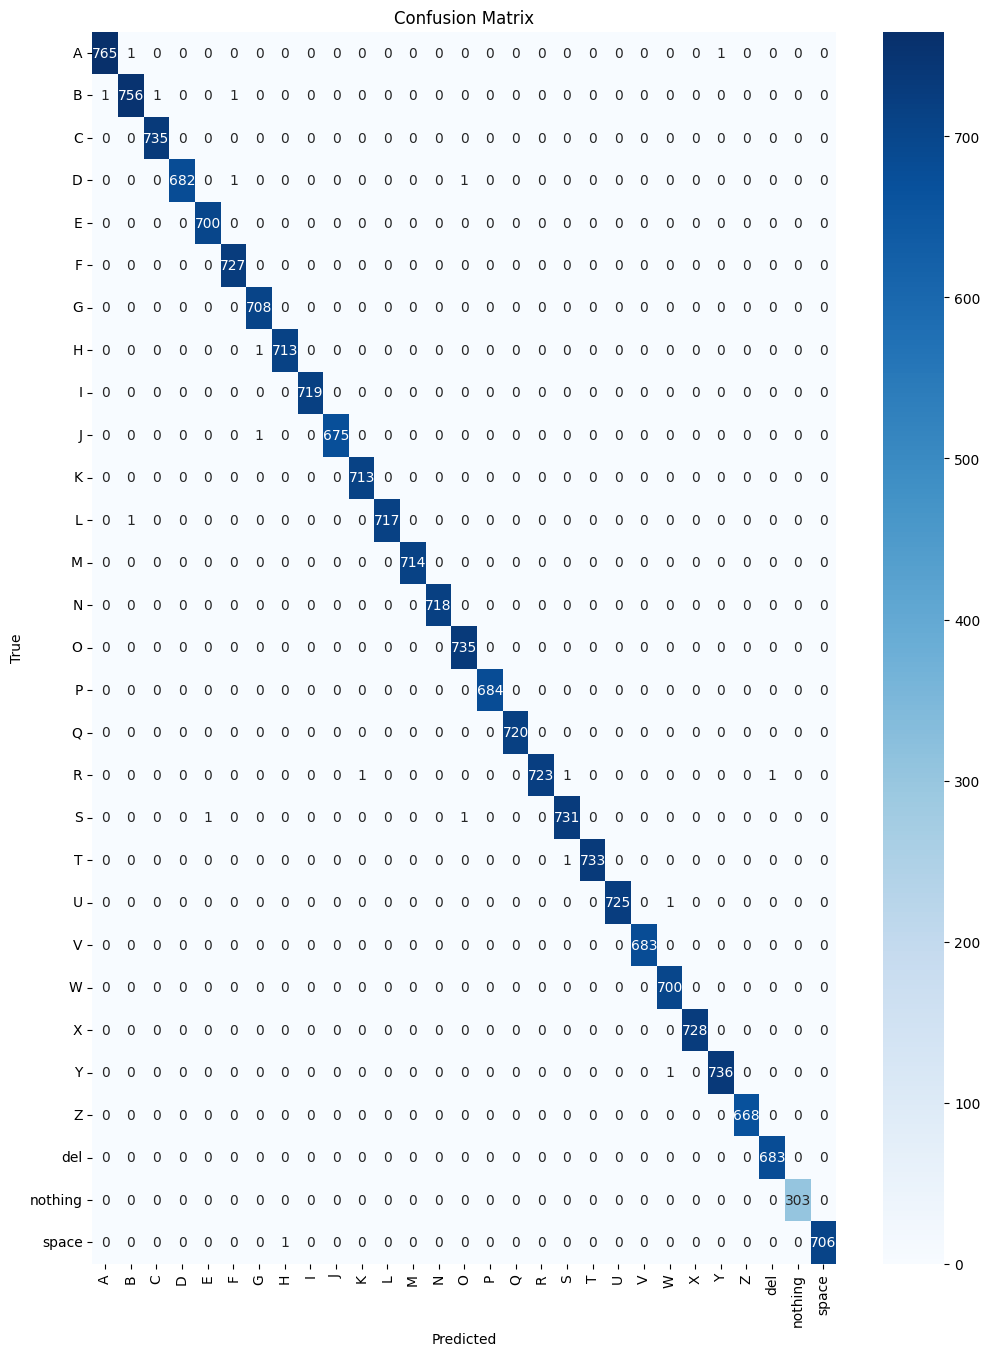

In [29]:
# Percorso del file salvato
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'
# Caricamento del modello
num_classes = 29
model = HandGestureCNN(num_classes=num_classes)

checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'del', 'nothing', 'space']

# Funzione per il calcolo delle metriche
def calculate_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=names)

    accuracy = np.sum(all_preds == all_labels) / len(all_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(class_report)

    plt.figure(figsize=(12, 16))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=names, yticklabels=names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Esegui il calcolo delle metriche
calculate_metrics(model, test_loader)

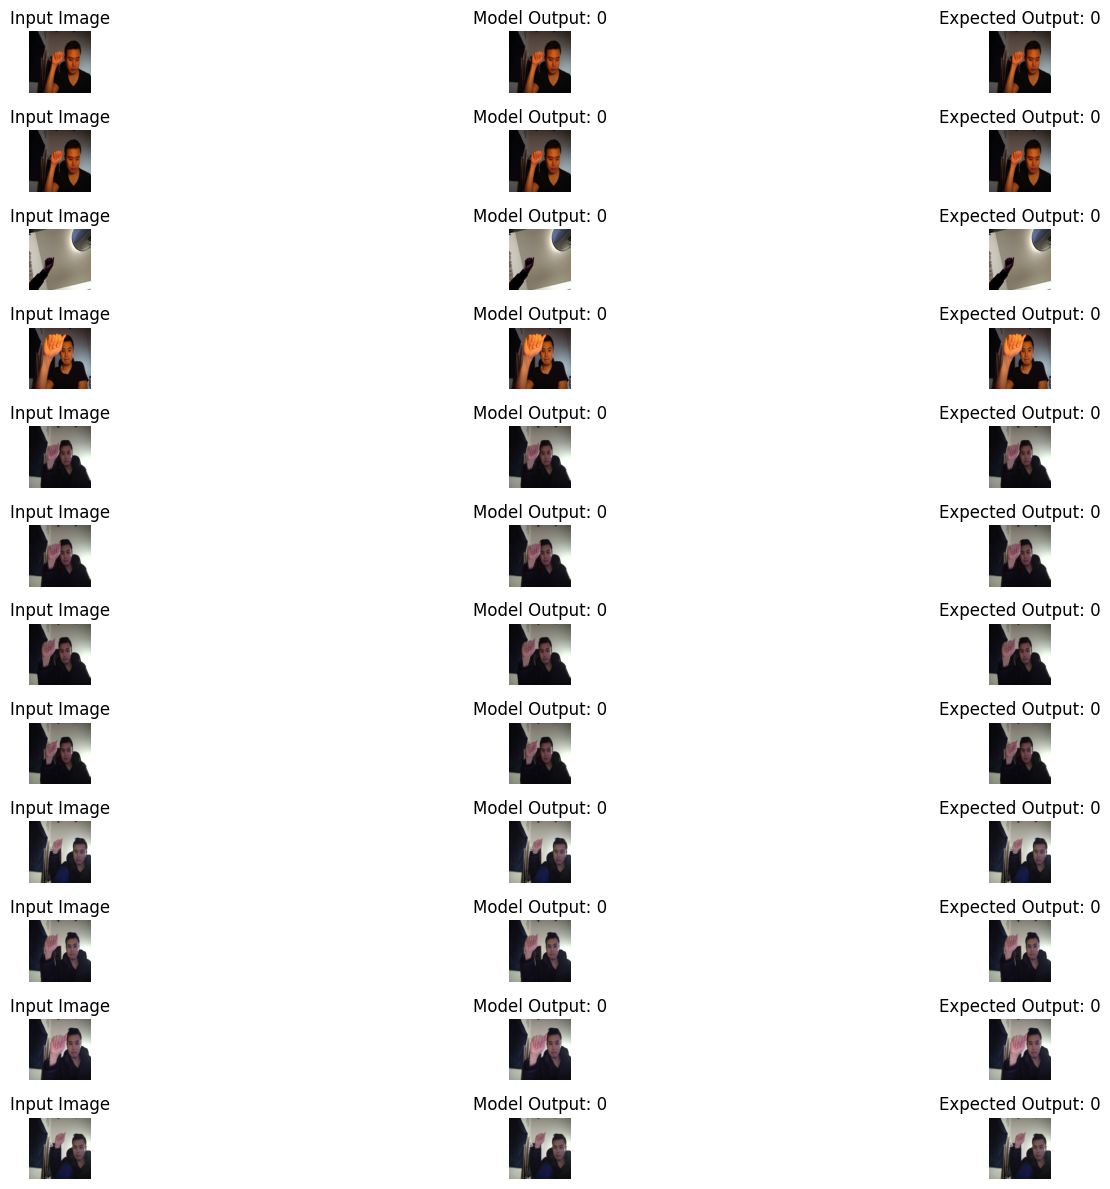

In [34]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Percorso del modello salvato
model_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/dataset_4_ASL/hand_gesture_cnn_with_metrics.pth'

# Imposta il dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caricare il modello e i pesi
num_classes = 29
model = HandGestureCNN(num_classes=num_classes)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Sposta il modello sul dispositivo corretto
model.eval()

# Definizione delle trasformazioni inverse per convertire i tensori in immagini
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    ToPILImage()
])

# Funzione per ottenere predizioni e immagini attese
def get_predictions_and_labels(dataset, model, num_images=12):
    images, preds, labels = [], [], []
    for i in range(num_images):
        input_image, label_index = dataset[i]
        with torch.no_grad():
            input_image = input_image.unsqueeze(0).to(device)  # Aggiungi batch dimension e sposta su device
            output = model(input_image)
            _, pred = torch.max(output, 1)

        images.append(input_image.squeeze(0).cpu())  # Rimuovi batch dimension e sposta su CPU
        preds.append(pred.item())
        labels.append(label_index)

    return images, preds, labels

# Ottieni 12 immagini, predizioni e etichette
images, preds, labels = get_predictions_and_labels(test_dataset, model)

# Plot delle immagini
plt.figure(figsize=(18, 12))
for i in range(12):
    # Immagine di input
    plt.subplot(12, 3, i * 3 + 1)
    plt.imshow(inverse_transform(images[i]))
    plt.title("Input Image")
    plt.axis('off')

    # Output del modello
    plt.subplot(12, 3, i * 3 + 2)
    pred_label = labels[preds[i]]
    plt.imshow(inverse_transform(images[i]))  # Cambia se hai una funzione di visualizzazione per l'output
    plt.title(f"Model Output: {pred_label}")
    plt.axis('off')

    # Immagine attesa (label)
    plt.subplot(12, 3, i * 3 + 3)
    label = labels[labels[i]]
    plt.imshow(inverse_transform(images[i]))  # Cambia se hai una funzione di visualizzazione per l'immagine attesa
    plt.title(f"Expected Output: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
